In [350]:
import pandas as pd
import numpy as np
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from tqdm import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

## Fetching data, training a classifier

For this tutorial, we'll be using the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset). In particular, for simplicity, we'll use a 2-class subset: atheism and christianity.

In [351]:
categories = [0, 1]
data_train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
data_test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)
class_names = ['Not Harmful', 'Harmful']

In [352]:
df = pd.concat([data_train,data_test])
df["objects"]=df["objects"].astype(str)
train, test = train_test_split(df, test_size=0.25)
ioi_copy=test.copy()

In [353]:
test = test.reset_index()[["binary_labels","objects"]]
train = train.reset_index()[["binary_labels","objects"]]

In [354]:
df.dtypes

Unnamed: 0             int64
Unnamed: 0_x           int64
id                    object
img                   object
labels                object
text                  object
processed_text        object
processed_text_alt    object
binary_labels          int64
Unnamed: 0_y           int64
objects               object
text_and_objects      object
dtype: object

In [355]:
print(train.shape)
print(test.shape)

(2525, 2)
(842, 2)


Let's use the tfidf vectorizer, commonly used for text.

In [356]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(train["objects"])
test_vectors = vectorizer.transform(test["objects"])

Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

In [357]:
rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=500,     # Number of trees in the forest.
    max_depth=30,         # Maximum depth of the trees.
    max_features="sqrt",
    min_samples_split=5,  # Minimum number of samples required to split an internal node.
    min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node.
    bootstrap=True,       # Use bootstrap samples when building trees.
    oob_score=True,       # Use out-of-bag samples to estimate the generalization accuracy.
    n_jobs=-1,            # Use all cores available.
    random_state=42,      # Random seed.
    class_weight="balanced" # Use balanced class weights to adjust for imbalanced dataset.
)
rf.fit(train_vectors, train["binary_labels"])

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=5, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=42)

In [358]:
pred = rf.predict(test_vectors)
print(f' Accuracy {sklearn.metrics.accuracy_score(test["binary_labels"], pred)}')
print(f' Precision {sklearn.metrics.precision_score(test["binary_labels"], pred, average="binary")}')
print(f' Recall {sklearn.metrics.recall_score(test["binary_labels"], pred, average="binary")}')
print(f' F1-Score {sklearn.metrics.f1_score(test["binary_labels"], pred, average="binary")}')

 Accuracy 0.5760095011876485
 Precision 0.43680709534368073
 Recall 0.6566666666666666
 F1-Score 0.5246338215712383


In [359]:
# Classification Report
from sklearn.metrics import classification_report

print("Classification Report on Test Set:")
print(classification_report(test["binary_labels"], pred))


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.74      0.53      0.62       542
           1       0.44      0.66      0.52       300

    accuracy                           0.58       842
   macro avg       0.59      0.59      0.57       842
weighted avg       0.63      0.58      0.58       842



## Explaining predictions using lime

Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implement ````predict_proba```` on raw_text lists.

In [360]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [361]:
print(c.predict_proba([test["objects"][0]]))

[[0.82597037 0.17402963]]


Now we create an explainer object. We pass the ````class_names```` as an argument for prettier display.

In [362]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

We then generate an explanation with at most 6 features for an arbitrary document in the test set.

In [363]:
df_pred = []
for idx in range(len(test)):
    text_instance = test["objects"][idx]
    # Ensure the text is valid and non-empty
    if text_instance and len(text_instance.split()) > 0:
        exp = explainer.explain_instance(text_instance, c.predict_proba, num_features=5)
        print('Document id: %d' % idx)
        dict_pred = {
            "id": idx,
            "Prob (Harmful)": c.predict_proba([text_instance])[0, 1],
            "True Class": class_names[train["binary_labels"][idx]],
            "Explainers": exp.as_list()
        }
        df_pred.append(dict_pred)
    else:
        print(f'Skipping document id: {idx} due to insufficient text')


Document id: 0
Document id: 1
Document id: 2
Document id: 3
Document id: 4
Document id: 5
Document id: 6
Skipping document id: 7 due to insufficient text
Document id: 8
Document id: 9
Skipping document id: 10 due to insufficient text
Document id: 11
Document id: 12
Document id: 13
Skipping document id: 14 due to insufficient text
Document id: 15
Document id: 16
Document id: 17
Document id: 18
Document id: 19
Document id: 20
Document id: 21
Document id: 22
Document id: 23
Document id: 24
Document id: 25
Document id: 26
Skipping document id: 27 due to insufficient text
Document id: 28
Document id: 29
Document id: 30
Document id: 31
Document id: 32
Document id: 33
Document id: 34
Document id: 35
Document id: 36
Document id: 37
Document id: 38
Document id: 39
Document id: 40
Document id: 41
Document id: 42
Document id: 43
Document id: 44
Document id: 45
Document id: 46
Document id: 47
Document id: 48
Document id: 49
Document id: 50
Document id: 51
Document id: 52
Document id: 53
Document i

In [364]:
df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"]>=0.5,"Harmful","Not Harmful")
df_pred

,id,Prob (Harmful),True Class,Explainers,Prob Class
0,0,0.174030,Not Harmful,"[(dog, -0.09452924978980755), (keyboard, 0.021...",Not Harmful
1,1,0.396258,Not Harmful,"[(cup, -0.20448242162980662), (tie, 0.15325328...",Not Harmful
2,2,0.906155,Not Harmful,"[(tie, 0.24011908208436156), (person, 0.040959...",Harmful
3,3,0.310667,Not Harmful,"[(bear, -0.21580716750247983), (tie, 0.0756220...",Not Harmful
4,4,0.538731,Not Harmful,"[(person, 0.08629519589992361)]",Harmful
...,...,...,...,...,...
783,837,0.538731,Harmful,"[(person, 0.08629519589992365)]",Harmful
784,838,0.538731,Not Harmful,"[(person, 0.08629519589992361)]",Harmful
785,839,0.538731,Not Harmful,"[(person, 0.08629519589992365)]",Harmful
786,840,0.559187,Harmful,"[(chair, -0.2631790265222987), (tie, 0.1525572...",Harmful


In [365]:
explainer_list=[]
c=0
for i in df_pred["Explainers"]:
    for k in i:
        explainer_dict={
            "id": c,
            "word":k[0],
            "value":k[1]
        }
        explainer_list.append(explainer_dict)
    c+=1
        
        
explainer_list=pd.DataFrame(explainer_list)
explainer_list = explainer_list.merge(df_pred, on="id")
explainer_list

,id,word,value,Prob (Harmful),True Class,Explainers,Prob Class
0,0,dog,-0.094529,0.174030,Not Harmful,"[(dog, -0.09452924978980755), (keyboard, 0.021...",Not Harmful
1,0,keyboard,0.021670,0.174030,Not Harmful,"[(dog, -0.09452924978980755), (keyboard, 0.021...",Not Harmful
2,1,cup,-0.204482,0.396258,Not Harmful,"[(cup, -0.20448242162980662), (tie, 0.15325328...",Not Harmful
3,1,tie,0.153253,0.396258,Not Harmful,"[(cup, -0.20448242162980662), (tie, 0.15325328...",Not Harmful
4,1,table,-0.020709,0.396258,Not Harmful,"[(cup, -0.20448242162980662), (tie, 0.15325328...",Not Harmful
...,...,...,...,...,...,...,...
1465,785,person,0.086295,0.728344,Not Harmful,"[(tie, 0.19339963718429148), (person, -0.00576...",Harmful
1466,786,chair,-0.263179,0.288372,Not Harmful,"[(vase, -0.10908884064805317), (chair, -0.0522...",Not Harmful
1467,786,tie,0.152557,0.288372,Not Harmful,"[(vase, -0.10908884064805317), (chair, -0.0522...",Not Harmful
1468,786,person,-0.083715,0.288372,Not Harmful,"[(vase, -0.10908884064805317), (chair, -0.0522...",Not Harmful


In [366]:
harmful_count = explainer_list.groupby(['word', 'Prob Class']).size().reset_index(name='count')
harmful_count = harmful_count.pivot_table(index='word', columns='Prob Class', values='count', fill_value=0)
harmful_count.columns = ['Not Harmful', 'Harmful']
harmful_count.reset_index(inplace=True)

harmful_count["count"] = harmful_count["Not Harmful"]+harmful_count["Harmful"]
harmful_count=harmful_count.sort_values(by="count", ascending=False).head(10)
#harmful_count = harmful_count.pivot_table(index='word', values=['Not Harmful', 'Harmful'], aggfunc='sum')
harmful_count

,word,Not Harmful,Harmful,count
50,person,364.0,275.0,639.0
69,tie,76.0,57.0,133.0
29,dog,27.0,17.0,44.0
23,chair,15.0,21.0,36.0
21,cat,15.0,19.0,34.0
27,cup,15.0,18.0,33.0
75,tv,19.0,10.0,29.0
14,bottle,17.0,10.0,27.0
13,book,10.0,14.0,24.0
51,phone,11.0,12.0,23.0


## Visualizing explanations

In [367]:
harmful_long = pd.melt(harmful_count, id_vars='word', var_name='Result', value_name='Count')
harmful_long.sort_values(by="word")

,word,Result,Count
18,book,Harmful,14.0
28,book,count,24.0
8,book,Not Harmful,10.0
27,bottle,count,27.0
17,bottle,Harmful,10.0
7,bottle,Not Harmful,17.0
14,cat,Harmful,19.0
4,cat,Not Harmful,15.0
24,cat,count,34.0
3,chair,Not Harmful,15.0


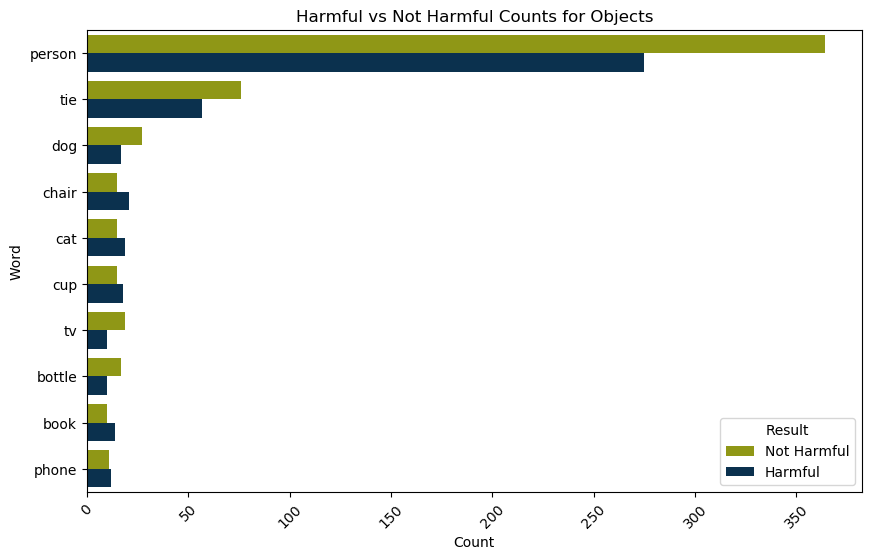

In [368]:
# Correcting the code snippet provided by the user and plotting the barplot accordingly
# First, we'll need to convert the DataFrame from wide to long format

# For the given data, we can use 'pd.melt' instead of 'pd.wide_to_long' for simplici
# Now, let's create the barplot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y='word', x='Count', hue='Result', data=harmful_long[harmful_long["Result"]!="count"], palette=['#A2AD00', '#003359'])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Harmful vs Not Harmful Counts for Objects')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/2.Top10HarmfulHarmlessObjectsCount.jpeg")


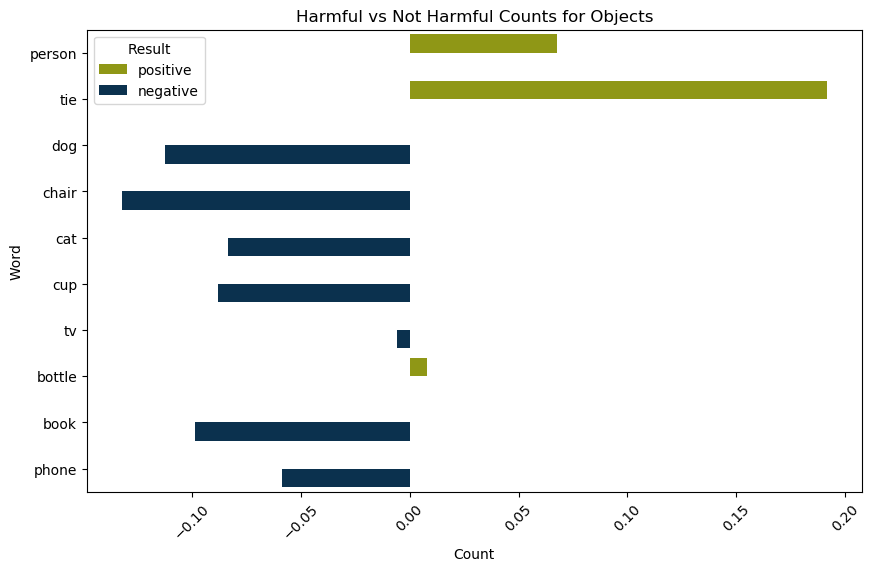

In [369]:
exp_val =explainer_list[["word","value"]].groupby("word").mean("value")
exp_val["dir"] = np.where(exp_val["value"]>=0,"positive","negative")

top10=harmful_long[harmful_long["Result"]!="count"][["word"]].drop_duplicates()

top10 = top10.merge(exp_val, how="inner",on="word")


plt.figure(figsize=(10, 6))
sns.barplot(y='word', x='value',hue="dir" , data=top10, palette=['#A2AD00', '#003359'])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Harmful vs Not Harmful Counts for Objects')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/2.Top10HarmfulHarmlessObjectsValues.jpeg")


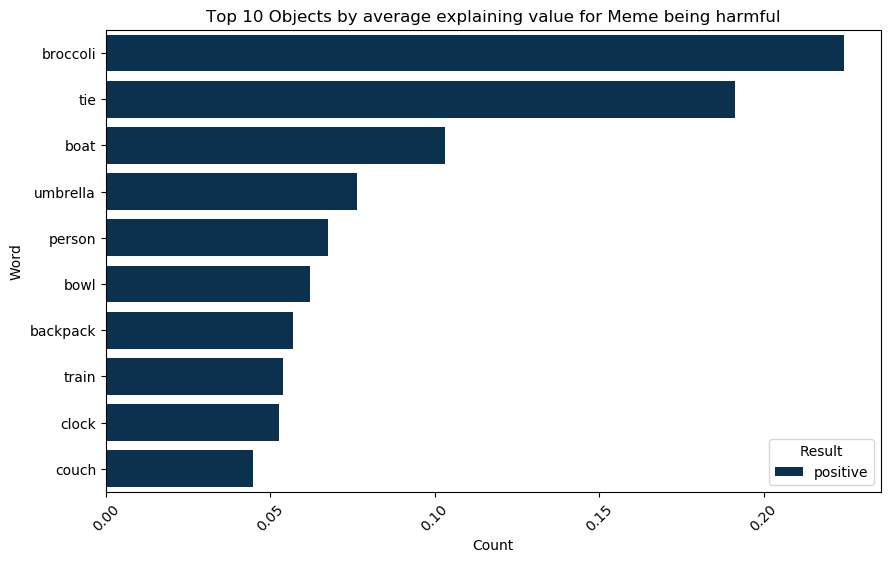

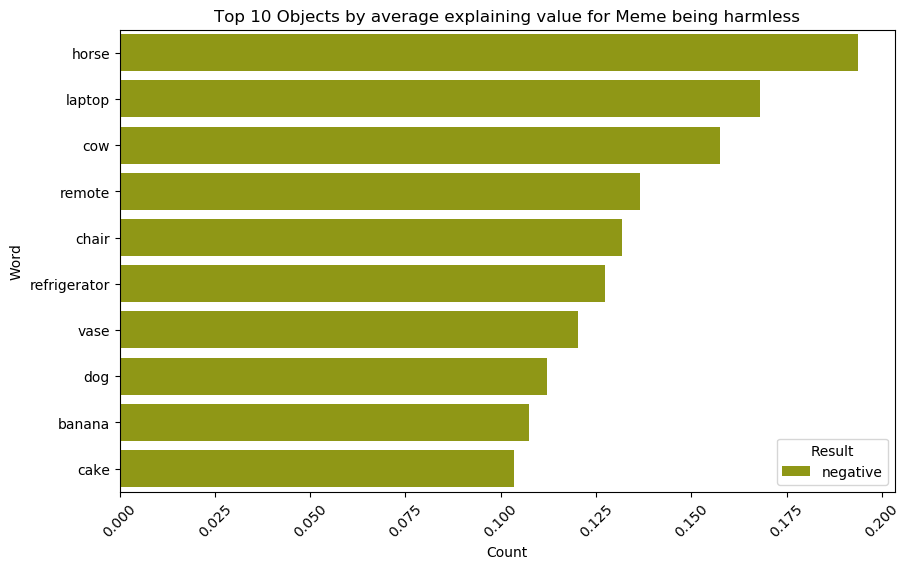

In [370]:
exp_p = exp_val[exp_val["dir"]=="positive"].sort_values("value",ascending=False).head(10)
exp_n = exp_val[exp_val["dir"]=="negative"].sort_values("value",ascending=True).head(10)
exp_n["value"]=exp_n["value"]*-1

plt.figure(figsize=(10, 6))
sns.barplot(y=exp_p.index, x='value',hue="dir" , data=exp_p, palette=["#003359"])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Top 10 Objects by average explaining value for Meme being harmful')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/2.Positive_Top10ObjectsByValues.jpeg")

plt.figure(figsize=(10, 6))
sns.barplot(y=exp_n.index, x='value',hue="dir" , data=exp_n, palette=["#A2AD00"])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Top 10 Objects by average explaining value for Meme being harmless')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/2.Negative_Top10ObjectsByValues.jpeg")


## Broccoli investigation

In [371]:
ioi = ioi_copy
ioi = ioi[ioi["objects"].str.contains("broccoli")]
ioi

,Unnamed: 0,Unnamed: 0_x,id,img,labels,text,processed_text,processed_text_alt,binary_labels,Unnamed: 0_y,objects,text_and_objects
2850,2850,2850,covid_memes_4776,covid_memes_4776.png,['not harmful'],The IndianEXPRESS\nConfused between\n#WorkProm...,indianexpress confused workpromhome workporhome,indianexpress confused workpromhome workporhome,0,598,bowl knife person person broccoli,indianexpress confused workpromhome workporhom...
2665,2665,2665,covid_memes_4410,covid_memes_4410.png,['not harmful'],"me, on my fourth round\nof turkey and gravy.\n...",round turkey gravy aunt karen i'm come thanksg...,fourth round turkey gravy aunt karen coming th...,0,39,person person cat person person teddy bear per...,fourth round turkey gravy aunt karen coming th...
2593,2593,2593,covid_memes_4280,covid_memes_4280.png,['not harmful'],2020 be like\nA\n,like,2020 like,0,1972,broccoli teddy bear,2020 like broccoli teddy bear
272,272,272,covid_memes_247,covid_memes_247.png,"['very harmful', 'society']",alot of wods pecete\nCHECK\nbamgi pa Tid-\nvE\...,alot wod pecete check bamgi pa tid- ve compies...,alot wods pecete check bamgi pa compiesi gor s...,1,255,broccoli broccoli,alot wods pecete check bamgi pa compiesi gor s...
1398,1398,1398,covid_memes_5120,covid_memes_5120.png,"['very harmful', 'society']",n Mer\nDark Memen and Gitv\nLIVE BREAKING NEWS...,n mer dark memen gitv live break news weed kil...,n mer dark memen gitv live breaking news weed ...,1,1844,broccoli,n mer dark memen gitv live breaking news weed ...
